<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/57_Ultra_Lite_%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D1%8F_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Ultra Lite

Макс 10 баллов

Перепишите сеть для генерации текста с нуля в новом ноутбуке. Можно подсматривать в ноутбук занятия, но крайне желательно писать код своими руками, а не копировать.

# Загрузка библиотек

In [ ]:
from google.colab import files # модуль для загрузки файлов в колаб
import numpy as np

from tensorflow.keras.models import Model, load_model # подгружаем абстрактный класс базовой модели, метод загрузки предобученной модели
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input
from tensorflow.keras.optimizers import RMSprop, Adadelta
from tensorflow.keras.preprocessing.sequence import pad_sequences # метод ограничения последовательностей заданной длиной
from tensorflow.keras.preprocessing.text import Tokenizer # токенизатор для обработки текста
from tensorflow.keras import utils # утилиты кераса для OHE 
from tensorflow.keras.utils import plot_model # удобный график для визуализации архитектуры модели

import yaml # модуль для удобной работы с файлами

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Парсинг данных

In [ ]:
'''
Открываем файл  диалогами
'''
corpus = open('/content/drive/MyDrive/Базы/Диалоги(рассказы)_censored.yml','r') # открываем файл с диалогами в режиме чтения
document = yaml.safe_load(corpus) # загружаем файл *глоссарий
conversations = document['разговоры'] # загружаем диалоги из файла из блока "разговоры" и заносим в conversations
print('Количество пар вопрос-ответ: {}'.format(len(conversations)))
print('Пример диалога : {}'.format(conversations[777]))

Количество пар вопрос-ответ: 11893
Пример диалога : ['Почему решили, что надо именно это?', 'Догадался.']


In [ ]:
'''
Разбираем вопросы и ответы с проставлением тегов ответам
'''
# Собираем вопросы и ответы в списки 
questions = list() # здесь будет список вопросов
answers = list() # здесь будет список ответов

# В каждом диалоге берем фразу и добавляем в лист
# Если в ответе не одна фраза, то сцепляем сколько есть
for con in conversations:     # для каждой пары вопро-ответ
  if len(con) > 2:            # если ответ содержит более 2 предложений (к-во реплик, к-во вариантов ответов)  
    questions.append(con[0])  # то вопросительную реплику отправляем в список вопросов
    replies = con[1:]         # а ответную составляем из соответствующих строк
    ans = ''                  # здесь соберем ответ
    for rep in replies:       # каждую реплику в ответной реплике 
      ans += ' ' + rep        
    answers.append(ans)       # добавим в список ответов
  elif len(con) > 1:          # если на 1 вопрос приходится 1 ответ
    questions.append(con[0])  # то вопросительную реплику отправляем в список вопросов
    answers.append(con[1])    # а ответную в список ответов

# Очищаем строки с неопределенным типом ответов
answerCleaned = list() 
for i in range(len(answers)):
  if type(answers[i]) == str:
    answerCleaned.append(answers[i]) # если тип - строка, то добавляем в ответы
  else:
    questions.pop(i)                 # если не строка, то ответ не добавился, и плюс убираем соответствующий вопрос

# Сделаем теги-метки для начала и конца ответов
answers = list()
for i in range(len(answerCleaned)):
  answers.append('<START>' + answerCleaned[i] + '<END>')

# Выведем обновленные данные на экран
print('Вопрос: {}'.format(questions[888]))
print('Ответ: {}'.format(answers[888]))
    

Вопрос: Толя, проверь, все?
Ответ: <START>Все, товарищ командир!<END>


In [ ]:
'''
Подключаем керасовский токенайзер и собираем словарь индексов
'''
tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions + answers)          # загружаем в токенизатор список вопросов-ответов для сборки словаря частотности
vocabularyItems = list(tokenizer.word_index.items()) # список с содержимым словаря
vocabularySize = len(vocabularyItems)+1              # размер словаря
print('Фрагмент словаря: {}'.format(vocabularyItems[:50]))
print('Размер словаря: {}'.format(vocabularySize))

Фрагмент словаря: [('start', 1), ('end', 2), ('что', 3), ('не', 4), ('я', 5), ('а', 6), ('ты', 7), ('это', 8), ('да', 9), ('в', 10), ('нет', 11), ('как', 12), ('и', 13), ('вы', 14), ('ну', 15), ('с', 16), ('на', 17), ('же', 18), ('так', 19), ('он', 20), ('у', 21), ('кто', 22), ('где', 23), ('все', 24), ('мы', 25), ('то', 26), ('мне', 27), ('тебя', 28), ('меня', 29), ('здесь', 30), ('еще', 31), ('почему', 32), ('о', 33), ('тебе', 34), ('там', 35), ('есть', 36), ('его', 37), ('за', 38), ('куда', 39), ('вот', 40), ('ничего', 41), ('вас', 42), ('знаю', 43), ('чем', 44), ('но', 45), ('она', 46), ('они', 47), ('ли', 48), ('чего', 49), ('вам', 50)]
Размер словаря: 15092


# Подготовка выборки

In [ ]:
'''
Устанавливаем закодированные входные данные (вопросы)
'''
tokenizedQuestions = tokenizer.texts_to_sequences(questions) # разбиваем текст вопросов на последовательности индексов
maxLenQuestions = max([len(x) for x in tokenizedQuestions]) # уточняем длину самого большого вопроса
# Делаем  последовательности одной длины, заполняя нулями более короткие вопросы
paddedQuestions = pad_sequences(tokenizedQuestions, maxlen=maxLenQuestions, padding='post')

# Предподготавливаем данные для входа в сеть
encoderForInput = paddedQuestions
print('Пример оригинального вопроса на вход: {}'.format(questions[100]))
print('Пример кодированного вопроса на вход: {}'.format(encoderForInput[100]))
print('Размеры закодированного массива на вход: {}'.format(encoderForInput.shape))
print('Установленная длина вопросов на вход: {}'.format(maxLenQuestions))

Пример оригинального вопроса на вход: Какая же мораль?
Пример кодированного вопроса на вход: [ 170   18 5703    0    0    0    0    0    0    0    0]
Размеры закодированного массива на вход: (11888, 11)
Установленная длина вопросов на вход: 11


In [ ]:
'''
Устанавливаем раскодированные входные данные (ответы)
'''
tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
maxLenAnswers = max([len(x) for x in tokenizedAnswers])  # уточняем длину самого большого ответа
# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')

# Предподготавливаем данные для входа в сеть
decoderForInput = paddedAnswers # переводим в numpy массив
print('Пример оригинального ответа на вход: {}'.format(answers[100]))
print('Пример раскодированного ответа на вход: {}'.format(decoderForInput[100]))
print('Размеры раскодированного массива ответов на вход: {}'.format(decoderForInput.shape))
print('Установленная длина ответов на вход : {}'.format(maxLenAnswers))

Пример оригинального ответа на вход: <START>Никакой. Так просто вспомнилось.<END>
Пример раскодированного ответа на вход: [    1   672    19    93 10547     2     0     0     0     0     0     0
     0]
Размеры раскодированного массива ответов на вход: (11888, 13)
Установленная длина ответов на вход : 13


In [ ]:
'''
Раскодированные выходные данные(ответы)
'''
tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
for i in range(len(tokenizedAnswers)):                   # для разбитых последовательностей ответов
  tokenizedAnswers[i] = tokenizedAnswers[i][1:]          # избавляемся от тега <START>
# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')

oneHotAnswers = utils.to_categorical(paddedAnswers, vocabularySize) # переводим в one hot vector
decoderForOutput = np.array(oneHotAnswers) # и сохраняем в виде массива numpy

In [ ]:
print('Пример раскодированного ответа на вход: {}'.format(decoderForInput[100][:21]))
print('Пример раскодированного ответа на выход: {}'.format(decoderForOutput[100][4][:21]))
print('Размеры раскодрованного массива ответов на выход: {}'.format(decoderForOutput.shape))
print('Установленная длина вопросов на выход: {}'.format(maxLenAnswers))

Пример раскодированного ответа на вход: [    1   672    19    93 10547     2     0     0     0     0     0     0
     0]
Пример раскодированного ответа на выход: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Размеры раскодрованного массива ответов на выход: (11888, 13, 15092)
Установленная длина вопросов на выход: 13


# Параметры нейросети и модель обучения

In [ ]:
'''
Первый входной слой, кодер, выходной слой
'''
encoderInputs = Input(shape=(None,)) # универсальный параметр под любой размер на вход(здесь будет encoderForOutput)
# Эти данные проходят через слой Embedding(длина словаря, размерность)
encoderEmbedding = Embedding(vocabularySize, 200, mask_zero=True)(encoderInputs) # mask_zero=True - значит нулевые вектора не анализируются 
# Затем выход с Embedding пойдет в LSTM слой, на выходе у которого будет два вектора состояния - state_h, state_c
# Вектора состояния state_h, state_c зададутся в LSTM слое декодера в блоке ниже
encoderOutputs, state_h, state_c = LSTM(200, return_state=True)(encoderEmbedding)
encoderStates = [state_h, state_c]

In [ ]:
from IPython.core.pylabtools import activate_matplotlib
'''
Второй выходной слой, декодер, выходной слой
'''
decoderInputs = Input(shape=(None,)) # размеры на входе сетки(здесь будет decoderForInput)
# Эти данные проходят через слой Embedding (длина словаря, размерность)
# mask_zero=True - игнорировать нулевые padding при передаче в LSTM. Предотвратит вывод ответа типа: "У меня все хорошо PAD PAD PAD PAD PAD PAD.."
decoderEmbedding = Embedding(vocabularySize, 200, mask_zero=True)(decoderInputs)
# Затем выход с Embedding пойдет в LSTM слой, которому передаются вектора состояния state_h, state_c
decoderLSTM = LSTM(200, return_state=True, return_sequences=True)
decoderOutputs, _, _ = decoderLSTM(decoderEmbedding, initial_state=encoderStates)
# И от LSTM'a сигнал decoderOutputs пропускаем через полносвязный слой с софтмаксом на выходе
decoderDense = Dense(vocabularySize, activation='softmax')
output = decoderDense(decoderOutputs)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, None, 200)    3018400     ['input_11[0][0]']               
                                                                                                  
 embedding_5 (Embedding)        (None, None, 200)    3018400     ['input_12[0][0]']               
                                                                                            

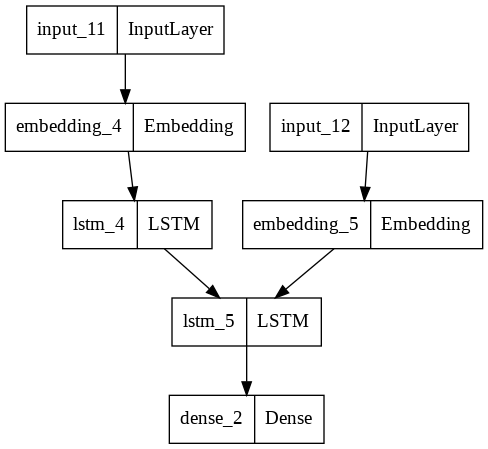

In [ ]:
'''
Собираем тренировочную модель нейросети
'''
model = Model([encoderInputs, decoderInputs], output)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')
print(model.summary())
plot_model(model, to_file='model.png') # построим график модели для визуализации слоев и связей между ними

In [ ]:
# Запустим обучение и сохраним модель
model.fit([encoderForInput, decoderForInput], decoderForOutput, batch_size=50, epochs=2)


Epoch 1/2
238/238 [==============================] - 41s 132ms/step - loss: 2.2135
Epoch 2/2
238/238 [==============================] - 31s 132ms/step - loss: 1.9757


In [ ]:
# Запустим обучение и сохраним модель
model.fit([encoderForInput, decoderForInput], decoderForOutput, batch_size=50, epochs=50 )
model.save( '/content/drive/MyDrive/Базы/Модели и веса к ДЗ/model_50epochs(rms).h5' )

Epoch 1/50
238/238 [==============================] - 31s 129ms/step - loss: 1.9264
Epoch 2/50
238/238 [==============================] - 31s 130ms/step - loss: 1.8864
Epoch 3/50
238/238 [==============================] - 30s 127ms/step - loss: 1.8495
Epoch 4/50
238/238 [==============================] - 31s 129ms/step - loss: 1.8158
Epoch 5/50
238/238 [==============================] - 31s 128ms/step - loss: 1.7845
Epoch 6/50
238/238 [==============================] - 31s 129ms/step - loss: 1.7527
Epoch 7/50
238/238 [==============================] - 31s 131ms/step - loss: 1.7216
Epoch 8/50
238/238 [==============================] - 33s 138ms/step - loss: 1.6866
Epoch 9/50
238/238 [==============================] - 31s 128ms/step - loss: 1.6511
Epoch 10/50
238/238 [==============================] - 30s 128ms/step - loss: 1.6138
Epoch 11/50
238/238 [==============================] - 30s 127ms/step - loss: 1.5799
Epoch 12/50
238/238 [==============================] - 30s 128ms/step - lo

In [ ]:
model.load_weights( '/content/drive/MyDrive/Базы/Модели и веса к ДЗ/model_50epochs(rms).h5' )

# Подготовка и запуск рабочей нейросети с генерацией ответов

In [ ]:
'''
Создаем рабочую модель для вывода ответов на запросы пользователя
'''
def makeInferenceModels():
  # Определим модель кодера, на входе будут закодированные вопросы(EncoderForInputs), на выходе состояния state_h, state_c
  encoderModel = Model(encoderInputs, encoderStates)

  decoderStateInput_h = Input(shape=(200,)) # обозначим размерность для входного слоя с состоянием state_h
  decoderStateInput_c = Input(shape=(200,)) # обозначим размерность для входного слоя с состоянием state_C

  decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c] # оба inputs запишем в decoderStatesInputs

  # Берем ответы, прошедшие через Embedding, вместе с состоянием и подаем их LSTM слою
  decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs)
  decoderStates = [state_h, state_c]            # LSTM даст нам новые состояния
  decoderOutputs = decoderDense(decoderOutputs) # и ответы, которые мы пропустим через полносвязный слой с софтмаксом

  # Определим модель декодера, на входе будут раскодированные ответы (decoderForInputs) и состояния
  # на выходе предсказываемый ответ и состояния
  decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)

  return encoderModel, decoderModel


In [ ]:
'''
Cоздадим функцию, которая преобразует вопрос пользователя в последовательность индексов
'''
def strToTokens(sentence:str): # функция принимает на вход строку (предложение с вопросом)
  words = sentence.lower().split() # приводит предложение к нижнему регистру и разбирает на слова
  tokenList = list()               # здесь будет последовательность токенов, индексов
  for word in words:               # для каждого слова в предложении
    tokenList.append(tokenizer.word_index[word]) # определяем токенизатором индекс и добавляем в список

    # Функция вернет вопрос в виде последовательности индексов, ограниченной длиной самого длинного вопроса из БД
  return pad_sequences([tokenList], maxlen=maxLenQuestions, padding='post') 

In [ ]:
'''
Устанавливаем окончательные настройки и запускаем модель 
'''
encModel, decModel = makeInferenceModels() # запускаем функцию для построения модели

for _ in range(3): #задаем кол-во вопросов и на каждой итерации в этом диапазоне:
  # Получаем значения состояний, которые определит кодер в соответствии с заданным вопросом
  statesValues = encModel.predict(strToTokens(input('Задайте вопрос: ')))
  # Создаем пустой массив размером 1,1
  emptyTargetSeq = np.zeros((1, 1))
  emptyTargetSeq[0, 0] = tokenizer.word_index['start']  # положим в пустую последовательность начальное слово start в виде индекса

  stopCondition = False    # зададим условие, при срабатывании которого прекратится генерация очередного слова
  decodedTranslation = ''  # здесь будет собираться генерируемый ответ
  while not stopCondition: # пока не сработало стоп условие
    # В модель декодера подадим пустую последовательность со словом start и состояния предсказанные кодером по заданному вопросу
    # декодер заменит слово start предсказанным словом и обновит состояния
    decOutputs, h, c = decModel.predict([emptyTargetSeq] + statesValues)

    # argmax побежит по вектору decOutputs'a[0, 0, 15092], найдет максимальное значение и вернет нам номер индекса под которым оно лежит в массиве
    sampledWordIndex = np.argmax(decOutputs[0, 0, :]) # argmax возьмем от оси, в которой 15092 элемента. Получили индекс предсказанного слова.
    sampledWord = None                                # создаем переменную, в которую положим слово.
    for word, index in tokenizer.word_index.items():
      if sampledWordIndex == index:                   # если индекс выбранного слова соответствует какому-то индексу из словаря
        decodedTranslation += ' {}'.format(word)       # слово, идущее под этим индексом в словаре, добавляется в итоговый ответ
        sampleWord = word                             # выбранное слово фиксируем в переменную sampleWord

    # если выбранным словом оказывается end либо если сгенерированный ответ превышает заданную максимальную длину ответа
    if sampleWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True                     # то срабатывает стоп-условие и прекращаем генерацию

    emptyTargetSeq[0, 0] = sampledWordIndex    # заносим туда индекс выбранного слова
    statesValues = [h, c]                      # и состояния, обновленные декодером
    # и продолжаем цикл с обновленными параметрами

  print(decodedTranslation[:-3]) # выводим ответ сгенерированный декодером



Задайте вопрос: привет
1/1 [==============================] - 0s 32ms/step
 что ты здесь делаешь 
Задайте вопрос: как дела
1/1 [==============================] - 0s 31ms/step
 вот так почему же не надо 
Задайте вопрос: ты откуда
1/1 [==============================] - 0s 30ms/step
 из за мной 


# Загрузка и запуск предобученной модели

In [ ]:
# Подгружаем модель из памяти и выведем ее параметры
model = load_model( '/content/drive/MyDrive/Базы/Модели и веса к ДЗ/model_50epochs(rms).h5' )
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, None, 200)    3018400     ['input_11[0][0]']               
                                                                                                  
 embedding_5 (Embedding)        (None, None, 200)    3018400     ['input_12[0][0]']               
                                                                                            

In [ ]:
'''
Устанавливаем связи между слоями рабочей модели и предобученной
'''
def loadInferenceModels():
  encoderInputs = model.input[0] # входом энкодера рабочей модели будет первый инпут предобученной модели (input_1)
  encoderEmbedding = model.layers[2] # связываем эмбеддинг слои(model.layers[2] - это embedding_1)
  encoderOutputs, state_h_enc, state_c_enc = model.layers[4].output # вытягиваем аутпуты из первого LSTM слоя обучающей модели и даем экодеру (lstm_1)
  encoderStates = [state_h_enc, state_c_enc] # кладем забранные состояния в состояние энкодера
  encoderModel = Model(encoderInputs, encoderStates) # формируем модель 

  decoderInputs = model.input[1] # входом декодера рабочей модели будет второй инпут предобученной модели (input_2)
  decoderStateInput_h = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_h
  decoderStateInput_c = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_c

  decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c] # возьмем оба inputs вместе  и запишем в decoderStatesInputs

  decoderEmbedding = model.layers[3] # связываем эмбеддинг слои (model.layers[3] - это embedding_2)
  decoderLSTM = model.layers[5]      # связываем LSTM слои(model.layers[5] - это lstm_2)
  decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding.output, initial_state = decoderStatesInputs)
  decoderStates = [state_h, state_c] # LSTM даст нам новые состояния

  decoderDense = model.layers[6] # связываем полносвязные слои (model.layers[6] - это dense_1)
  decoderOutputs = decoderDense(decoderOutputs) # выход с LSTM мы пропустим через полносвязный слой с софтмаксом

  # Определим модель декодера, на входе далее будут раскодированные ответы (decoderForInputs) и состояния
  # на выходе предсказываемый ответ и новые состояния
  decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)
  return encoderModel, decoderModel

In [ ]:
'''
Устанавливаем окончательные настройки и запускаем рабочую модель над предобученной
'''
encModel, decModel = loadInferenceModels() # запускаем функцию построения модели кодера и декодера

for _ in range(6): #задаем количество вопросов, и на каждой итерации в этом диапазоне:
  # Получаем значения состояний, которые определит кодер в соответствии с заданным вопросом
  statesValues = encModel.predict(strToTokens(input('Задайте вопрос: ')))
  # Создаем пустой массив (1, )
  emptyTargetSeq = np.zeros((1, 1))
  emptyTargetSeq[0, 0] = tokenizer.word_index['start'] # подаем в пустую последовательность тег <start>, в виде индекса
  stopCondition = False # зададим условие, при срабатывании которого, прекратится генерация очередного слова
  decodedTranslation = '' # здесь будет собираться генерируемый ответ
  while not stopCondition : # пока не сработало стоп-условие
    # В модель декодера подадим пустую последовательность со словом 'start' и состояния предсказанные кодером по заданному вопросу.
    # декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
    
    #argmax пробежит по вектору decOutputs'а[0,0,15104], найдет макс.значение, и вернёт нам номер индекса под которым оно лежит в массиве
    sampledWordIndex = np.argmax( decOutputs[0, 0, :]) # argmax возьмем от оси, в которой 15092 элемента. Получили индекс предсказанного слова.
    sampledWord = None # создаем переменную, в которую положим слово, преобразованное на естественный язык
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index:              # если индекс выбранного слова соответствует какому-то индексу из словаря
        decodedTranslation += ' {}'.format(word) # слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
        sampledWord = word                       # выбранное слово фиксируем в переменную sampledWord
    
    # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True # то срабатывает стоп-условие и прекращаем генерацию

    emptyTargetSeq = np.zeros((1, 1))       # создаем пустой массив
    emptyTargetSeq[0, 0] = sampledWordIndex # заносим туда индекс выбранного слова
    statesValues = [h, c]                   # и состояния, обновленные декодером
    # и продолжаем цикл с обновленными параметрами
  
  print(decodedTranslation[:-3]) # выводим ответ сгенерированный декодером



Задайте вопрос: привет
1/1 [==============================] - 0s 27ms/step
 что ты здесь делаешь 
Задайте вопрос: кто ты
1/1 [==============================] - 0s 25ms/step
 я вы к могу 
Задайте вопрос: откуда ты
1/1 [==============================] - 0s 26ms/step
 с оно не знаю а как они 
Задайте вопрос: знаешь меня
1/1 [==============================] - 0s 28ms/step
 а ты почему бы это можно 
Задайте вопрос: как дела
1/1 [==============================] - 0s 28ms/step
 вот так почему же не надо 
Задайте вопрос: сколько тебе лет
1/1 [==============================] - 0s 28ms/step
 не знаю а сколько нужно 
